## Can nets learn from imbalance?

### Experiments with ReLU thresholding

ReLU uses 0 ($p=0.5$) as an activation threshold in the log odds space. 

However, in imbalanced data, the threshold may not be appropriate. This experiment tries to track the impact of thresholding on the learning process.

Author: https://www.github.com/deburky

## Datasets

We create different imbalanced datasets to test the performance of the ReLU thresholds.

In [1]:
# -*- coding: utf-8 -*-
from sklearn.datasets import make_classification

# Generate synthetic balanced binary classification data
def generate_imbalanced_data(num_samples=1000, num_features=10, imbalance_ratio=0.1):
    """
    Generate imbalanced binary classification data.

    Parameters:
    - num_samples: Total number of samples
    - num_features: Number of features

    Returns:
    - X: Feature matrix
    - y: Labels
    """
    X, y = make_classification(
        n_samples=num_samples,
        n_features=num_features,
        n_informative=num_features,
        n_redundant=0,
        n_clusters_per_class=1,
        weights=[1 - imbalance_ratio, imbalance_ratio],
    )
    return X, y

## Experiment

We use bootstrapping to estimate the confidence intervals of the results.

In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, TensorDataset, random_split
from scipy.special import logit, expit
from sklearn.metrics import log_loss, roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Custom ReLU activation function
class CustomReLU(nn.Module):
    def __init__(self, threshold=0):
        super().__init__()
        self.threshold = threshold

    def forward(self, x):
        return torch.max(torch.tensor(self.threshold, dtype=x.dtype, device=x.device), x)

# Neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, threshold):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.relu = CustomReLU(threshold=threshold)
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Parameters
NUM_EPOCHS = 30
NUM_SAMPLES = 1_000
N_BOOTSTRAP = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-5

# Helper function to train and evaluate the model
def train_and_evaluate(model, dataloader_train, dataloader_test, criterion, optimizer, binary_threshold=0.5):
    # Train the model
    for _ in range(NUM_EPOCHS):
        model.train()
        for inputs, targets in dataloader_train:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    all_outputs, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in dataloader_test:
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs)
            all_outputs.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Convert to numpy arrays
    all_outputs = np.vstack(all_outputs)
    all_targets = np.vstack(all_targets)

    # Compute metrics
    auc_score = roc_auc_score(all_targets, all_outputs)
    gini_score = auc_score * 2 - 1
    log_likelihood = log_loss(all_targets, all_outputs)
    balanced_acc = balanced_accuracy_score(all_targets, all_outputs > binary_threshold)

    return {"Gini Score": gini_score, "Log-Likelihood": log_likelihood, "Balanced Accuracy": balanced_acc}

# Main loop for imbalance ratios and bootstrap iterations
results = []
chosen_confidence = 0.5
lower_bound = (1 - chosen_confidence) / 2
upper_bound = (1 + chosen_confidence) / 2

for ratio in np.linspace(0.01, 0.3, 30):
    # Generate imbalanced data
    X, y = generate_imbalanced_data(num_samples=NUM_SAMPLES, imbalance_ratio=ratio, num_features=10)
    logit_threshold = logit(ratio)

    # Convert to PyTorch tensors
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
    dataset_indices = np.arange(len(dataset))

    # Train and evaluate models
    for model_type, threshold in [("ReLU threshold=0", 0), ("ReLU threshold=logit(y)", logit_threshold)]:
        bootstrap_metrics = []
        for _ in range(N_BOOTSTRAP):
            # Create bootstrap sample and split
            bootstrap_indices = np.random.choice(dataset_indices, size=len(dataset_indices), replace=True)
            bootstrap_subset = Subset(dataset, bootstrap_indices)
            train_size = int(0.7 * len(bootstrap_subset))
            train_dataset, test_dataset = random_split(bootstrap_subset, [train_size, len(bootstrap_subset) - train_size])

            # Create DataLoaders
            dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
            dataloader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

            # Train and evaluate
            model = SimpleNN(input_dim=10, threshold=threshold)
            criterion = nn.BCEWithLogitsLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
            metrics = train_and_evaluate(model, dataloader_train, dataloader_test, criterion, optimizer, binary_threshold=expit(logit_threshold))
            bootstrap_metrics.append(metrics)

        # Aggregate metrics
        bootstrap_df = pd.DataFrame(bootstrap_metrics)
        aggregated_metrics = {
            "Imbalance Ratio": ratio,
            "Model Type": model_type,
            "Gini Score": bootstrap_df["Gini Score"].mean(),
            "Gini Score CI Lower": bootstrap_df["Gini Score"].quantile(lower_bound),
            "Gini Score CI Upper": bootstrap_df["Gini Score"].quantile(upper_bound),
            "Balanced Accuracy": bootstrap_df["Balanced Accuracy"].mean(),
            "Balanced Accuracy CI Lower": bootstrap_df["Balanced Accuracy"].quantile(lower_bound),
            "Balanced Accuracy CI Upper": bootstrap_df["Balanced Accuracy"].quantile(upper_bound),
            "Log-Likelihood": bootstrap_df["Log-Likelihood"].mean(),
            "Log-Likelihood CI Lower": bootstrap_df["Log-Likelihood"].quantile(lower_bound),
            "Log-Likelihood CI Upper": bootstrap_df["Log-Likelihood"].quantile(upper_bound),
        }
        results.append(aggregated_metrics)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

## Visualize the metrics

In this step we plot the metrics across different imbalance ratios and model types.

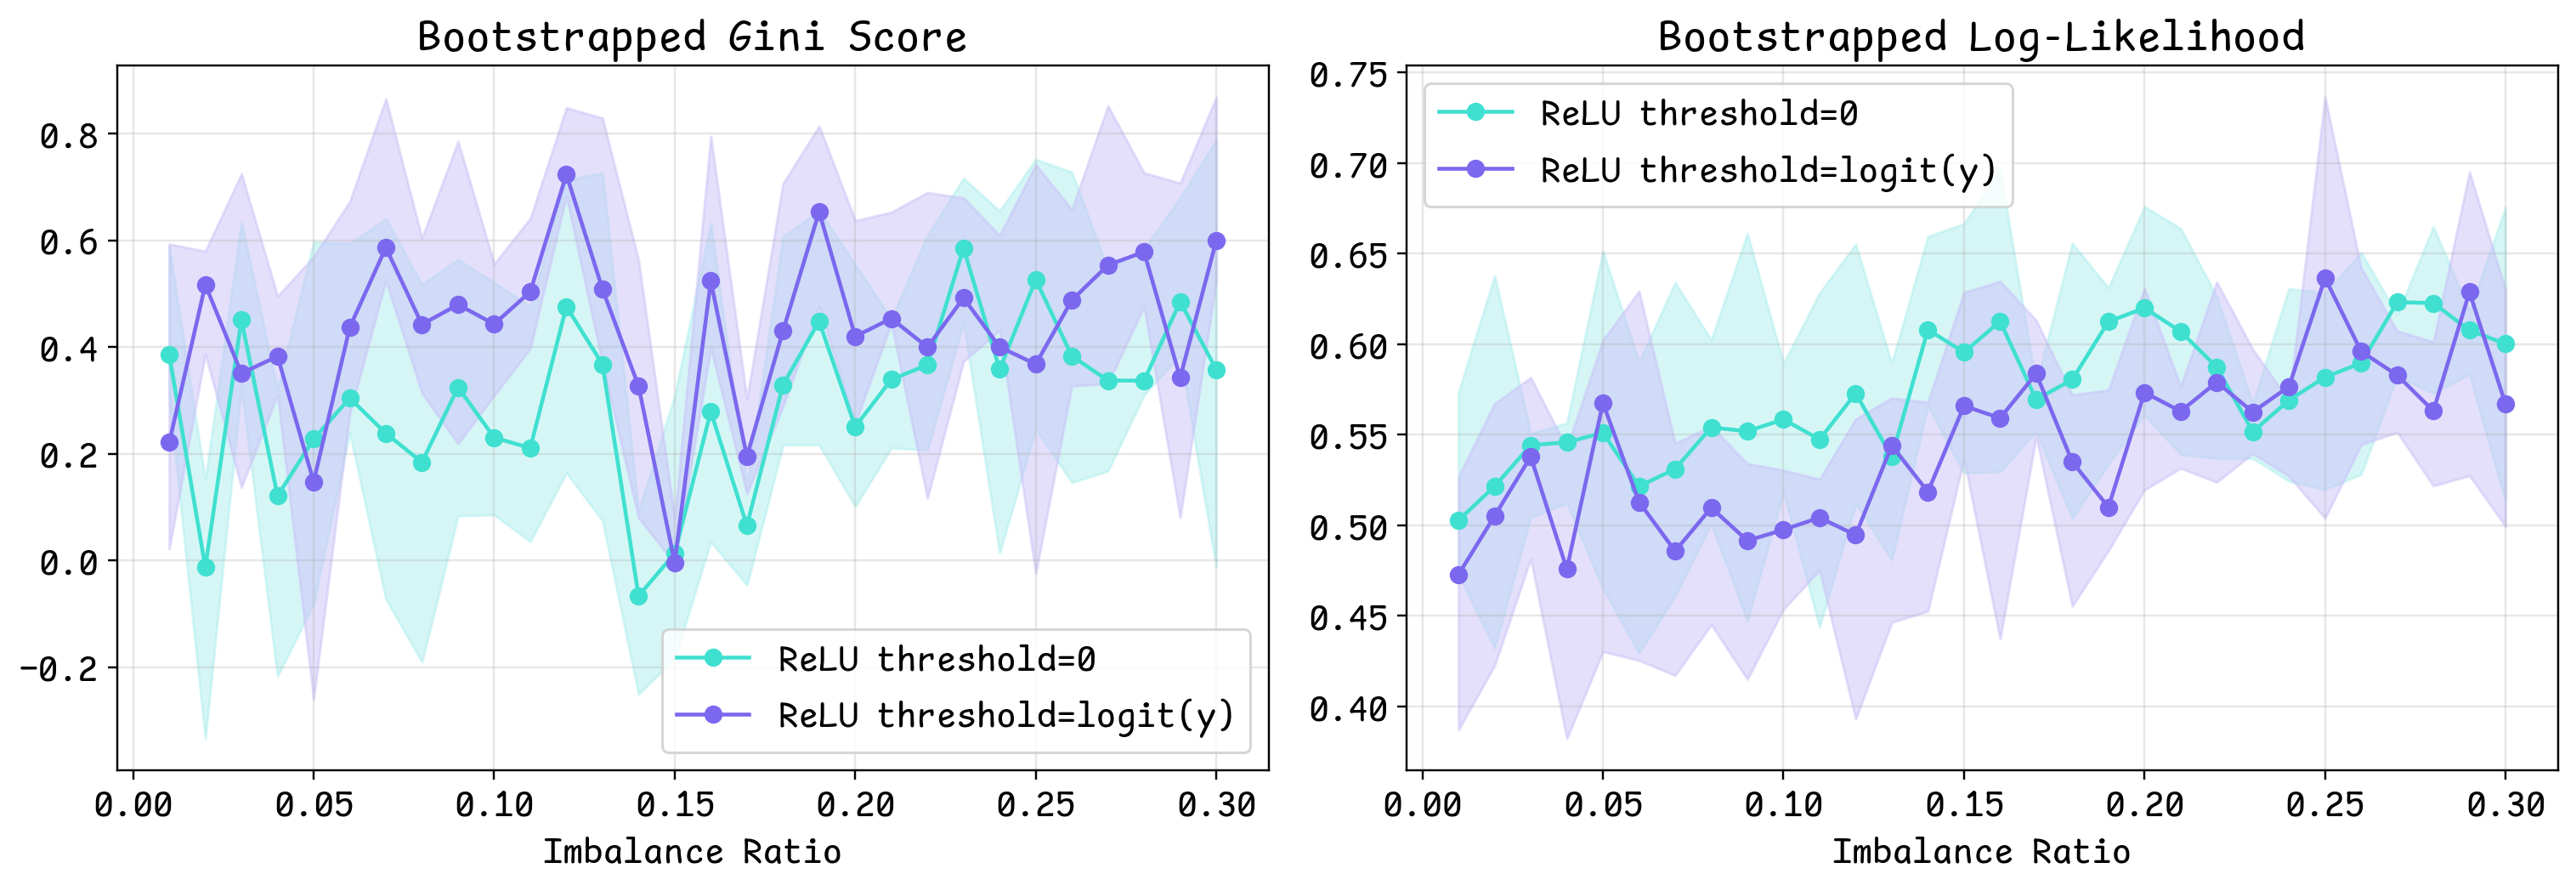

In [10]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
%config InlineBackend.figure_format = 'retina'

# Path to font file
font_path = "/Users/deburky/Library/Fonts/comic shanns 2.ttf"
fm.fontManager.addfont(font_path)
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
plt.rcParams.update({"font.size": 14})

def plot_results(results_df, metric1, metric2):
    """
    Plots two selected metrics from the results_df.

    Parameters:
    - results_df: DataFrame containing results with metrics and confidence intervals.
    - metric1: First metric to plot (e.g., "Gini Score").
    - metric2: Second metric to plot (e.g., "Log-Likelihood").
    """
    fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=110)

    _plot_metrics(results_df, ax, 0, metric1)
    _plot_metrics(results_df, ax, 1, metric2)
    plt.tight_layout()
    plt.show()

def _plot_metrics(results_df, ax, arg2, arg3):
    # Plot the first metric
    for model_type in results_df["Model Type"].unique():
        model_data = results_df[results_df["Model Type"] == model_type]
        color = 'turquoise' if model_type == "ReLU threshold=0" else "#7B68EE"
        color_fill = '#AFEEEE' if model_type == "ReLU threshold=0" else "#CAC2F8"
        ax[arg2].plot(
            model_data["Imbalance Ratio"],
            model_data[arg3],
            label=model_type,
            marker='o',
            color=color,
        )
        ax[arg2].fill_between(
            model_data["Imbalance Ratio"],
            model_data[f"{arg3} CI Lower"],
            model_data[f"{arg3} CI Upper"],
            color=color_fill,
            alpha=0.5,
        )
    ax[arg2].set_title(f"Bootstrapped {arg3}")
    ax[arg2].set_xlabel("Imbalance Ratio")
    ax[arg2].legend()
    ax[arg2].grid(alpha=0.3)

# Plot Gini Score and Log-Likelihood
plot_results(results_df, "Gini Score", "Log-Likelihood")